<a href="https://colab.research.google.com/github/YonDraco/learn-pyimagesearch/blob/master/2_transfer_learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

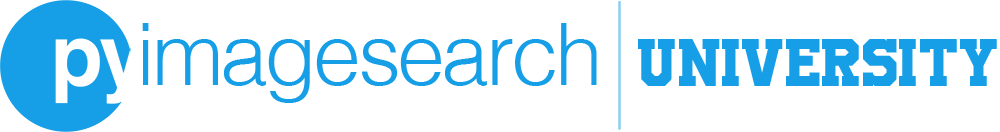

# Transfer Learning with Image Classification in PyTorch
### by [PyImageSearch.com](http://www.pyimagesearch.com)

## Welcome to **[PyImageSearch University](https://pyimg.co/university)** Jupyter Notebooks!

This notebook is associated with the [Transfer Learning with Image Classification in PyTorch](https://www.pyimagesearch.com/2021/10/11/transfer-learning-with-image-classification-in-pytorch/) blog post published on 2021-10-11.

Only the code for the blog post is here. Most codeblocks have a 1:1 relationship with what you find in the blog post with two exceptions: (1) Python classes are not separate files as they are typically organized with PyImageSearch projects, and (2) Command Line Argument parsing is replaced with an `args` dictionary that you can manipulate as needed.

We recommend that you execute (press ▶️) the code block-by-block, as-is, before adjusting parameters and `args` inputs. Once you've verified that the code is working, you are welcome to hack with it and learn from manipulating inputs, settings, and parameters. For more information on using Jupyter and Colab, please refer to these resources:

*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb)

As a reminder, these PyImageSearch University Jupyter Notebooks are not for sharing; please refer to the **Copyright** directly below and **Code License Agreement** in the last cell of this notebook. 

Happy hacking!

*Adrian*

<hr>

***Copyright:*** *The contents of this Jupyter Notebook, unless otherwise indicated, are Copyright 2021 Adrian Rosebrock, PyimageSearch.com. All rights reserved. Content like this is made possible by the time invested by the authors. If you received this Jupyter Notebook and did not purchase it, please consider making future content possible by joining PyImageSearch University at https://pyimg.co/university today.*

### Download the code zip file

In [1]:
!wget https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/transfer-learning-pytorch/transfer-learning-pytorch.zip
!unzip -qq transfer-learning-pytorch.zip
%cd transfer-learning-pytorch

--2021-08-26 02:32:11--  https://pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com/transfer-learning-pytorch/transfer-learning-pytorch.zip
Resolving pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)... 52.218.137.65
Connecting to pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3.us-west-2.amazonaws.com)|52.218.137.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 784546 (766K) [application/zip]
Saving to: ‘transfer-learning-pytorch.zip’

transfer-learning-p 100%[===================>] 766.16K  1.11MB/s    in 0.7s    

2021-08-26 02:32:13 (1.11 MB/s) - ‘transfer-learning-pytorch.zip’ saved [784546/784546]

/content/transfer-learning-pytorch


### Download the dataset

In [2]:
!wget -qq https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar xf flower_photos.tgz

## Blog Post Code

### Import Packages

In [3]:
# import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet50
from torchvision import transforms
from tqdm import tqdm
from torch import nn
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
import time
import os

### Our Configuration File

In [4]:
class Config:
    # define path to the original dataset and base path to the dataset
    # splits
    DATA_PATH = "flower_photos"
    BASE_PATH = "dataset"

    # define validation split and paths to separate train and validation
    # splits
    VAL_SPLIT = 0.1
    TRAIN = os.path.join(BASE_PATH, "train")
    VAL = os.path.join(BASE_PATH, "val")

    # specify ImageNet mean and standard deviation and image size
    MEAN = [0.485, 0.456, 0.406]
    STD = [0.229, 0.224, 0.225]
    IMAGE_SIZE = 224

    # determine the device to be used for training and evaluation
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    # specify training hyperparameters
    FEATURE_EXTRACTION_BATCH_SIZE = 256
    FINETUNE_BATCH_SIZE = 64
    PRED_BATCH_SIZE = 4
    EPOCHS = 20
    LR = 0.001
    LR_FINETUNE = 0.0005

    # define paths to store training plots and trained model
    WARMUP_PLOT = os.path.join("output", "warmup.png")
    FINETUNE_PLOT = os.path.join("output", "finetune.png")
    WARMUP_MODEL = os.path.join("output", "warmup_model.pth")
    FINETUNE_MODEL = os.path.join("output", "finetune_model.pth")

# instantiate a config object
config = Config()

### Data loading

In [5]:
def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
	# create a dataset and use it to create a data loader
	ds = datasets.ImageFolder(root=rootDir,
		transform=transforms)
	loader = DataLoader(ds, batch_size=batchSize,
		shuffle=shuffle,
		num_workers=os.cpu_count(),
		pin_memory=True if config.DEVICE == "cuda" else False)

	# return a tuple of  the dataset and the data loader
	return (ds, loader)

### Build the dataset

In [6]:
def copy_images(imagePaths, folder):
    # check if the destination folder exists and if not create it
    if not os.path.exists(folder):
        os.makedirs(folder)

    # loop over the image paths
    for path in imagePaths:
        # grab image name and its label from the path and create
        # a placeholder corresponding to the separate label folder
        imageName = path.split(os.path.sep)[-1]
        label = path.split(os.path.sep)[1]
        labelFolder = os.path.join(folder, label)

        # check to see if the label folder exists and if not create it
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)

        # construct the destination image path and copy the current
        # image to it
        destination = os.path.join(labelFolder, imageName)
        shutil.copy(path, destination)

In [7]:
# load all the image paths and randomly shuffle them
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(config.DATA_PATH))
np.random.shuffle(imagePaths)

[INFO] loading image paths...


In [8]:
# generate training and validation paths
valPathsLen = int(len(imagePaths) * config.VAL_SPLIT)
trainPathsLen = len(imagePaths) - valPathsLen
trainPaths = imagePaths[:trainPathsLen]
valPaths = imagePaths[trainPathsLen:]

# copy the training and validation images to their respective
# directories
print("[INFO] copying training and validation images...")
copy_images(trainPaths, config.TRAIN)
copy_images(valPaths, config.VAL)

[INFO] copying training and validation images...


### Fine-tuning the network

In [9]:
# define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.RandomResizedCrop(config.IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])
valTransform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

In [10]:
# create data loaders
(trainDS, trainLoader) = get_dataloader(config.TRAIN,
	transforms=trainTansform, batchSize=config.FINETUNE_BATCH_SIZE)
(valDS, valLoader) = get_dataloader(config.VAL,
	transforms=valTransform, batchSize=config.FINETUNE_BATCH_SIZE,
	shuffle=False)

In [11]:
# load up the ResNet50 model
model = resnet50(pretrained=True)
numFeatures = model.fc.in_features

# loop over the modules of the model and set the parameters of
# batch normalization modules as not trainable
for module, param in zip(model.modules(), model.parameters()):
    if isinstance(module, nn.BatchNorm2d):
        param.requires_grad = False

# define the network head and attach it to the model
headModel = nn.Sequential(
    nn.Linear(numFeatures, 512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(trainDS.classes))

)
model.fc = headModel

# append a new classification top to our feature extractor and pop it
# on to the current device
model = model.to(config.DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=config.LR)

In [13]:
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.FINETUNE_BATCH_SIZE
valSteps = len(valDS) // config.FINETUNE_BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
    "val_acc": []}

[INFO] training the network...


  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
  5%|▌         | 1/20 [00:18<05:58, 18.85s/it]

[INFO] EPOCH: 1/20
Train loss: 0.823321, Train accuracy: 0.6939
Val loss: 1.251666, Val accuracy: 0.8202


 10%|█         | 2/20 [00:37<05:37, 18.73s/it]

[INFO] EPOCH: 2/20
Train loss: 0.636297, Train accuracy: 0.7775
Val loss: 0.754403, Val accuracy: 0.8147


 15%|█▌        | 3/20 [00:56<05:18, 18.75s/it]

[INFO] EPOCH: 3/20
Train loss: 0.540590, Train accuracy: 0.8126
Val loss: 0.400597, Val accuracy: 0.8774


 20%|██        | 4/20 [01:14<04:59, 18.70s/it]

[INFO] EPOCH: 4/20
Train loss: 0.493301, Train accuracy: 0.8353
Val loss: 0.366718, Val accuracy: 0.8965


 25%|██▌       | 5/20 [01:33<04:39, 18.64s/it]

[INFO] EPOCH: 5/20
Train loss: 0.470465, Train accuracy: 0.8329
Val loss: 0.361365, Val accuracy: 0.8692


 30%|███       | 6/20 [01:52<04:21, 18.67s/it]

[INFO] EPOCH: 6/20
Train loss: 0.440136, Train accuracy: 0.8359
Val loss: 0.394205, Val accuracy: 0.8828


 35%|███▌      | 7/20 [02:11<04:03, 18.73s/it]

[INFO] EPOCH: 7/20
Train loss: 0.435377, Train accuracy: 0.8483
Val loss: 0.333476, Val accuracy: 0.8992


 40%|████      | 8/20 [02:29<03:44, 18.72s/it]

[INFO] EPOCH: 8/20
Train loss: 0.392409, Train accuracy: 0.8635
Val loss: 0.374314, Val accuracy: 0.8883


 45%|████▌     | 9/20 [02:48<03:25, 18.66s/it]

[INFO] EPOCH: 9/20
Train loss: 0.342309, Train accuracy: 0.8780
Val loss: 0.506566, Val accuracy: 0.8828


 50%|█████     | 10/20 [03:07<03:07, 18.79s/it]

[INFO] EPOCH: 10/20
Train loss: 0.366102, Train accuracy: 0.8738
Val loss: 0.281367, Val accuracy: 0.9237


 55%|█████▌    | 11/20 [03:26<02:48, 18.76s/it]

[INFO] EPOCH: 11/20
Train loss: 0.413624, Train accuracy: 0.8601
Val loss: 0.376808, Val accuracy: 0.8937


 60%|██████    | 12/20 [03:45<02:30, 18.86s/it]

[INFO] EPOCH: 12/20
Train loss: 0.378187, Train accuracy: 0.8744
Val loss: 0.401042, Val accuracy: 0.8856


 65%|██████▌   | 13/20 [04:04<02:12, 18.88s/it]

[INFO] EPOCH: 13/20
Train loss: 0.356690, Train accuracy: 0.8789
Val loss: 0.271430, Val accuracy: 0.9210


 70%|███████   | 14/20 [04:22<01:53, 18.88s/it]

[INFO] EPOCH: 14/20
Train loss: 0.315179, Train accuracy: 0.8916
Val loss: 0.308339, Val accuracy: 0.9046


 75%|███████▌  | 15/20 [04:41<01:34, 18.91s/it]

[INFO] EPOCH: 15/20
Train loss: 0.317231, Train accuracy: 0.8940
Val loss: 0.360801, Val accuracy: 0.9128


 80%|████████  | 16/20 [05:00<01:15, 18.91s/it]

[INFO] EPOCH: 16/20
Train loss: 0.291819, Train accuracy: 0.8952
Val loss: 0.302646, Val accuracy: 0.9210


 85%|████████▌ | 17/20 [05:19<00:56, 18.94s/it]

[INFO] EPOCH: 17/20
Train loss: 0.287301, Train accuracy: 0.9004
Val loss: 0.402469, Val accuracy: 0.9101


 90%|█████████ | 18/20 [05:38<00:37, 18.97s/it]

[INFO] EPOCH: 18/20
Train loss: 0.340796, Train accuracy: 0.8837
Val loss: 0.293286, Val accuracy: 0.9074


 95%|█████████▌| 19/20 [05:57<00:18, 18.94s/it]

[INFO] EPOCH: 19/20
Train loss: 0.300515, Train accuracy: 0.8965
Val loss: 0.246456, Val accuracy: 0.9455


100%|██████████| 20/20 [06:16<00:00, 18.84s/it]

[INFO] EPOCH: 20/20
Train loss: 0.290142, Train accuracy: 0.9007
Val loss: 0.296374, Val accuracy: 0.9292
[INFO] total time taken to train the model: 376.83s


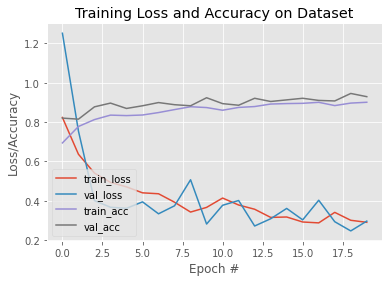

In [14]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.EPOCHS)):
    # set the model in training mode
    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)

        # calculate the gradients
        loss.backward()

        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)

            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(config.FINETUNE_PLOT)

# serialize the model to disk
torch.save(model, config.FINETUNE_MODEL)

### Drawing an Inference

In [15]:
# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-m", "--model", required=True,
#    help="path to trained model model")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
    "model": "output/finetune_model.pth"
}

# build our data pre-processing pipeline
testTransform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.MEAN, std=config.STD)
])

In [16]:
# calculate the inverse mean and standard deviation
invMean = [-m/s for (m, s) in zip(config.MEAN, config.STD)]
invStd = [1/s for s in config.STD]

# define our de-normalization transform
deNormalize = transforms.Normalize(mean=invMean, std=invStd)

In [17]:
# initialize our test dataset and data loader
print("[INFO] loading the dataset...")
(testDS, testLoader) = get_dataloader(config.VAL,
    transforms=testTransform, batchSize=config.PRED_BATCH_SIZE,
    shuffle=True)

# check if we have a GPU available, if so, define the map location
# accordingly
if torch.cuda.is_available():
    map_location = lambda storage, loc: storage.cuda()

# otherwise, we will be using CPU to run our model
else:
    map_location = "cpu"

# load the model
print("[INFO] loading the model...")
model = torch.load(args["model"], map_location=map_location)

# move the model to the device and set it in evaluation mode
model.to(config.DEVICE)
model.eval()

# grab a batch of test data
batch = next(iter(testLoader))
(images, labels) = (batch[0], batch[1])

# initialize a figure
fig = plt.figure("Results", figsize=(10, 10))

[INFO] loading the dataset...
[INFO] loading the model...


<Figure size 720x720 with 0 Axes>

[INFO] performing inference...


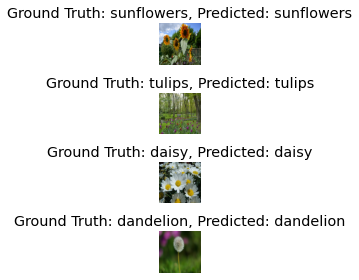

In [18]:
# switch off autograd
with torch.no_grad():
    # send the images to the device
    images = images.to(config.DEVICE)

    # make the predictions
    print("[INFO] performing inference...")
    preds = model(images)

    # loop over all the batch
    for i in range(0, config.PRED_BATCH_SIZE):
        # initialize a subplot
        ax = plt.subplot(config.PRED_BATCH_SIZE, 1, i + 1)

        # grab the image, de-normalize it, scale the raw pixel
        # intensities to the range [0, 255], and change the channel
        # ordering from channels first tp channels last
        image = images[i]
        image = deNormalize(image).cpu().numpy()
        image = (image * 255).astype("uint8")
        image = image.transpose((1, 2, 0))

        # grab the ground truth label
        idx = labels[i].cpu().numpy()
        gtLabel = testDS.classes[idx]

        # grab the predicted label
        pred = preds[i].argmax().cpu().numpy()
        predLabel = testDS.classes[pred]

        # add the results and image to the plot
        info = "Ground Truth: {}, Predicted: {}".format(gtLabel,
            predLabel)
        plt.imshow(image)
        plt.title(info)
        plt.axis("off")

    # show the plot
    plt.tight_layout()
    plt.show()

For a detailed walkthrough of the concepts and code, be sure to refer to the full tutorial, [*Transfer Learning with Image Classification in PyTorch*](https://www.pyimagesearch.com/2021/10/11/transfer-learning-with-image-classification-in-pytorch/) published on 2021-10-11.

# Code License Agreement
```
Copyright (c) 2021 PyImageSearch.com

SIMPLE VERSION
Feel free to use this code for your own projects, whether they are
purely educational, for fun, or for profit. THE EXCEPTION BEING if
you are developing a course, book, or other educational product.
Under *NO CIRCUMSTANCE* may you use this code for your own paid
educational or self-promotional ventures without written consent
from Adrian Rosebrock and PyImageSearch.com.

LONGER, FORMAL VERSION
Permission is hereby granted, free of charge, to any person obtaining
a copy of this software and associated documentation files
(the "Software"), to deal in the Software without restriction,
including without limitation the rights to use, copy, modify, merge,
publish, distribute, sublicense, and/or sell copies of the Software,
and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be
included in all copies or substantial portions of the Software.
Notwithstanding the foregoing, you may not use, copy, modify, merge,
publish, distribute, sublicense, create a derivative work, and/or
sell copies of the Software in any work that is designed, intended,
or marketed for pedagogical or instructional purposes related to
programming, coding, application development, or information
technology. Permission for such use, copying, modification, and
merger, publication, distribution, sub-licensing, creation of
derivative works, or sale is expressly withheld.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND,
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS
BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN
ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```